In [ ]:
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Models

# **Dataset:**
Bangkok past 120 months daily average AQI from https://aqicn.org/data-platform/register/

aqicn.org data-sources: **Division of Air Quality Data, Air Quality and Noise Management Bureau, Pollution Control Department.**

In [ ]:
# cols = ["date", " pm2.5", "o3", "so2", "co"]
df = pd.read_csv('bangkok-air-quality.csv')
df.head()


,date,pm25,pm10,o3,no2,so2,co
0,2023/12/1,85,39,15,1,,
1,2023/12/2,69,34,20,,,
2,2023/12/3,68,30,18,,,
3,2023/12/4,73,41,22,,,
4,2023/12/5,100,40,24,3,,


#Time series Analysis


In [ ]:
df = pd.read_csv('bangkok-air-quality.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3622 entries, 0 to 3621
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3622 non-null   object
 1    pm25   3622 non-null   object
 2    pm10   3622 non-null   object
 3    o3     3622 non-null   object
 4    no2    3622 non-null   object
 5    so2    3622 non-null   object
 6    co     3622 non-null   object
dtypes: object(7)
memory usage: 198.2+ KB


In [ ]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [ ]:
#drop column and check
columnstodrop = [' pm25', ' o3', ' no2', ' so2', ' co']
df.drop(columns=columnstodrop, inplace=True)
df

,date,pm10
0,2023/12/1,39
1,2023/12/2,34
2,2023/12/3,30
3,2023/12/4,41
4,2023/12/5,40
...,...,...
3617,2015/3/15,
3618,2014/11/30,
3619,2013/12/31,
3620,2014/1/26,


In [ ]:
pd.to_datetime(df.index)
df = df.sort_values(by='date', ascending=True)
# df.set_index('date')
df

,date,pm10
3619,2013/12/31,
3526,2014/1/1,84
3535,2014/1/10,67
3536,2014/1/11,67
3537,2014/1/12,64
...,...,...
134,2023/9/5,22
135,2023/9/6,31
136,2023/9/7,26
137,2023/9/8,19


In [ ]:
# df = df.set_index('date')
df

,pm10
date,
2013-12-31,
2014-01-01,84
2014-01-10,67
2014-01-11,67
2014-01-12,64
...,...
2023-09-05,22
2023-09-06,31
2023-09-07,26


In [ ]:
df[' pm10'] = pd.to_numeric(df[' pm10'], errors='coerce')

In [ ]:
mean_value = df[' pm10'].mean()
df[' pm10'].fillna(mean_value, inplace=True)
df

,pm10
date,
2013-12-31,39.451345
2014-01-01,84.000000
2014-01-10,67.000000
2014-01-11,67.000000
2014-01-12,64.000000
...,...
2023-09-05,22.000000
2023-09-06,31.000000
2023-09-07,26.000000


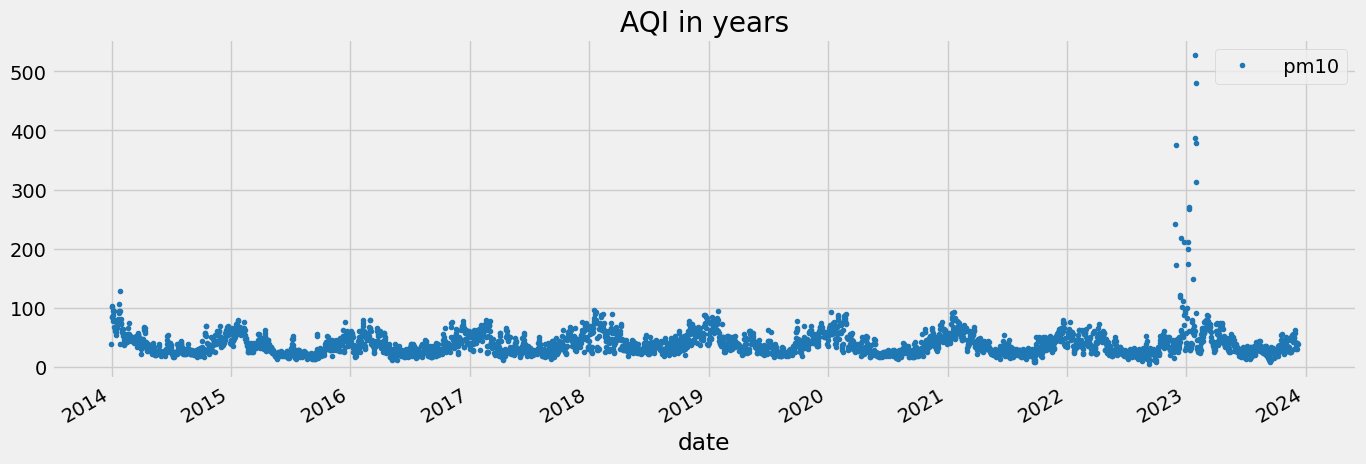

In [ ]:
df.plot(style = '.', figsize = (15,5),
        color = color_pal[0],
        title = 'AQI in years')
plt.show()

# Train / Test Split


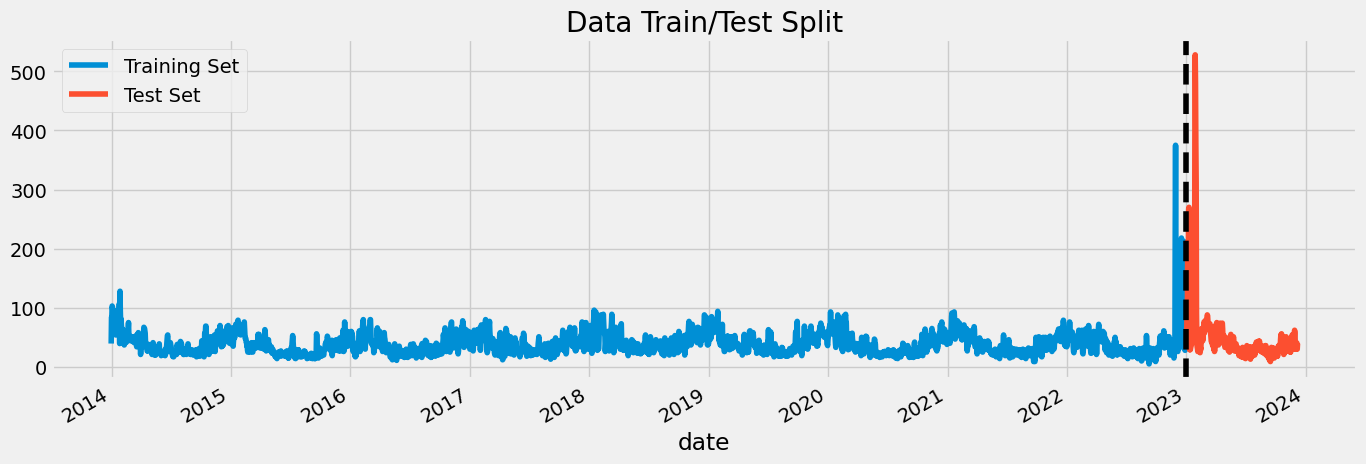

In [ ]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2023', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])


plt.show()

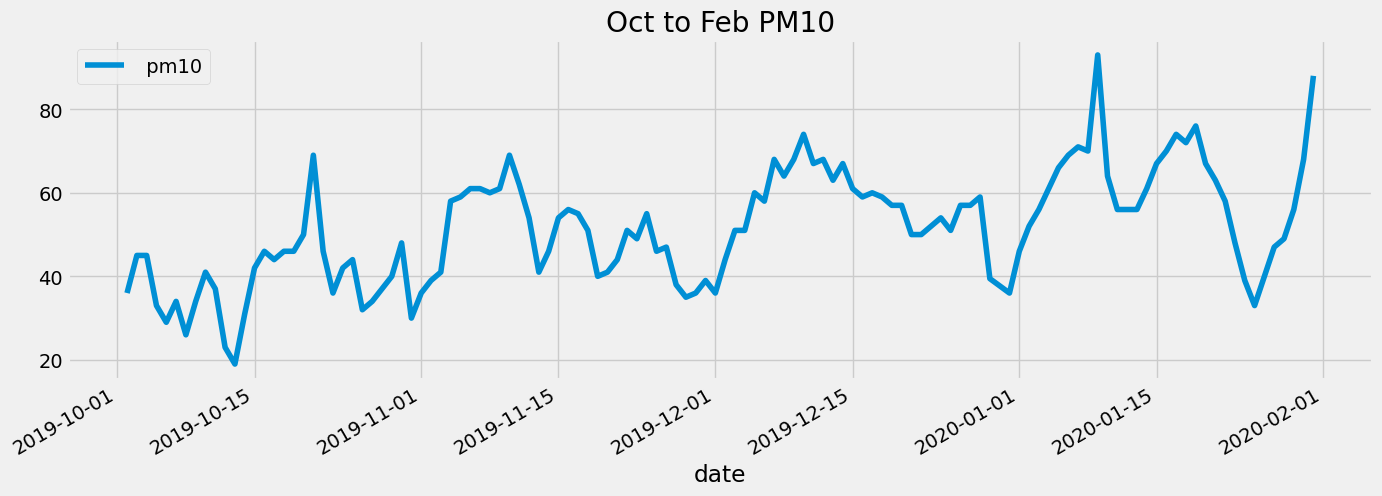

In [ ]:
df.loc[(df.index > '10-01-2019') & (df.index < '02-01-2020')]\
    .plot(figsize=(15, 5), title='Oct to Feb PM10')
plt.show()



#Outlier Analysis and removal


In [ ]:
# df[' pm10'].plot(kind='hist', bins=50)

NameError: ignored

#Feature Creation

In [ ]:
df.index.

DatetimeIndex(['2013-12-31', '2014-01-01', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17',
               ...
               '2023-09-28', '2023-09-29', '2023-09-03', '2023-09-30',
               '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-09'],
              dtype='datetime64[ns]', name='date', length=3622, freq=None)

# Real time, forecasted Air Quality Index(AQI) using API

In [ ]:
class AQIInfo:

    def __init__(self, api_key_iqair, api_key_aqicn):
        self.geolocator = Nominatim(user_agent='putinboonpetch@gmail.com')
        self.api_key_iqair = api_key_iqair
        self.api_key_aqicn = api_key_aqicn

    def get_coordinates(self, location_input):
        try:
            location = self.geolocator.geocode(location_input)
            if location:
                return location.latitude, location.longitude
            else:
                raise ValueError("Location not found.")
        except Exception as e:
            print(f"Error getting coordinates: {e}")
            return None

    def get_current_aqi_iqair(self, latitude, longitude):
        url = f"http://api.airvisual.com/v2/nearest_city?lat={latitude}&lon={longitude}&key={self.api_key_iqair}"

        try:
            response = requests.get(url)
            data = response.json()

            if 'data' in data:
                city = data['data']['city']
                state = data['data']['state']
                country = data['data']['country']
                current_aqi = data['data']['current']['pollution']['aqius']

                return city, state, country, current_aqi
            else:
                raise ValueError("Error retrieving data.")
        except requests.exceptions.RequestException as req_err:
            print(f"IQAir API request error occurred: {req_err}")
            return None

    def get_forecast_aqi_aqicn(self, latitude, longitude):
        url = f"https://api.waqi.info/feed/geo:{latitude};{longitude}/"
        params = {"token": self.api_key_aqicn}

        try:
            response = requests.get(url, params=params)
            response.raise_for_status()

            data = response.json()
            forecast_aqi = data.get('data', {})\
            .get('forecast', {})\
            .get('daily', {})\
            .get('pm10', [{}])\
             [0].get('avg')

            return forecast_aqi
        except requests.exceptions.RequestException as req_err:
            print(f"AQICN API request error occurred: {req_err}")
            return None

    def get_aqi_info(self, location_input):
        coordinates = self.get_coordinates(location_input)

        if coordinates:
            latitude, longitude = coordinates

            # Get current AQI using IQAir API
            current_aqi_info = self.get_current_aqi_iqair(latitude, longitude)

            if current_aqi_info:
                city, state, country, current_aqi = current_aqi_info

                print(f"Location: City: {city}, State: {state}, Country: {country}")
                print(f"Current AQI: {current_aqi}")

                # Interpret the current AQI (you can modify this part based on your interpretation logic)
                self.interpret_aqi(current_aqi)

                # Get forecast AQI using AQICN API
                forecast_aqi = self.get_forecast_aqi_aqicn(latitude, longitude)

                if forecast_aqi is not None:
                    print(f"\nForecast AQI: {forecast_aqi}")

                    # Interpret the forecast AQI (you can modify this part based on your interpretation logic)
                    self.interpret_aqi(forecast_aqi)

    def interpret_aqi(self, aqi):
        if aqi >= 0 and aqi <= 50:
          print("Air quality is considered satisfactory, and air pollution poses little or no risk.")
        elif aqi >= 51 and aqi <= 100:
          print("Air quality is acceptable; however, there may be some concern for individuals who are unusually sensitive to air pollution.")
        elif aqi >= 101 and aqi <= 150:
          print("Unhealthy for Sensitive Groups - Members of sensitive groups may experience health effects, but the general public is less likely to be affected.")
        elif aqi >= 151 and aqi <= 200:
          print("Unhealthy - Everyone may begin to experience adverse health effects, and members of sensitive groups may experience more serious effects.")
        elif aqi >= 201 and aqi <= 300:
          print("Very Unhealthy - Health alert: everyone may experience more serious health effects.")
        elif aqi >= 301 and aqi <= 500:
          print("Hazardous - Health warnings of emergency conditions; the entire population is likely to be affected.")
        else:
          print("Invalid AQI value.")

# Usage example
# YOUR_IQAIR_API_KEY = 'your_iqair_api_key'
YOUR_IQAIR_API_KEY = '3528b24d-9229-4723-930c-cecb82c2e57d'
# YOUR_AQICN_API_KEY = 'your_aqicn_api_key'
YOUR_AQICN_API_KEY = '19aed57f5a65b9f85d3bdcbc9e8632eeda9c7803'
aqi_info = AQIInfo(api_key_iqair=YOUR_IQAIR_API_KEY, api_key_aqicn=YOUR_AQICN_API_KEY)

location_input = input('Input your location name here: ')
aqi_info.get_aqi_info(location_input)


Input your location name here: Sutthisan
Location: City: Huai Khwang, State: Bangkok, Country: Thailand
Current AQI: 70
Air quality is acceptable; however, there may be some concern for individuals who are unusually sensitive to air pollution.

Forecast AQI: 46
Air quality is considered satisfactory, and air pollution poses little or no risk.


# test

In [ ]:
import requests
from geopy.geocoders import Nominatim

class AQIInfo:

    def __init__(self, api_key_iqair, api_key_aqicn):
        self.geolocator = Nominatim(user_agent='putinboonpetch@gmail.com')
        self.api_key_iqair = api_key_iqair
        self.api_key_aqicn = api_key_aqicn

    def get_coordinates(self, location_input):
        try:
            location = self.geolocator.geocode(location_input)
            if location:
                return location.latitude, location.longitude
            else:
                raise ValueError("Location not found.")
        except Exception as e:
            print(f"Error getting coordinates: {e}")
            return None

    def get_forecast_aqi_iqair(self, latitude, longitude):
        # Adjust this method based on the IQAir API documentation
        url = f"https://api.iqair.com/forecast/{latitude}/{longitude}/"
        headers = {"apikey": self.api_key_iqair}

        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()

            # Extract and return the forecast AQI for IQAir API
            forecast_aqi = response.json()['data']['forecast']['pm10']['day']['avg']
            return forecast_aqi
        except requests.exceptions.RequestException as req_err:
            print(f"IQAir API request error occurred: {req_err}")
        return None

    def get_forecast_aqi_aqicn(self, latitude, longitude):
        # Adjust this method based on the AQICN API documentation
        url = f"https://api.waqi.info/feed/geo:{latitude};{longitude}/"
        params = {"token": self.api_key_aqicn}

        try:
            response = requests.get(url, params=params)
            response.raise_for_status()

            # Extract and return the forecast AQI for AQICN API
            forecast_aqi = response.json()['data']['forecast']['daily']['pm10'][0]['avg']
            return forecast_aqi
        except requests.exceptions.RequestException as req_err:
            print(f"AQICN API request error occurred: {req_err}")
        return None

    def get_forecast_aqi(self, location_input):
        coordinates = self.get_coordinates(location_input)

        if coordinates:
            latitude, longitude = coordinates
            # Call the appropriate API method based on your needs
            # For example, using IQAir API:
            # forecast_aqi = self.get_forecast_aqi_iqair(latitude, longitude)
            # Or using AQICN API:
            forecast_aqi = self.get_forecast_aqi_aqicn(latitude, longitude)

            return forecast_aqi

        return None

    def interpret_aqi(self, aqi):
        if aqi >= 0 and aqi <= 50:
          print("Air quality is considered satisfactory, and air pollution poses little or no risk.")
        elif aqi >= 51 and aqi <= 100:
          print("Air quality is acceptable; however, there may be some concern for individuals who are unusually sensitive to air pollution.")
        elif aqi >= 101 and aqi <= 150:
          print("Unhealthy for Sensitive Groups - Members of sensitive groups may experience health effects, but the general public is less likely to be affected.")
        elif aqi >= 151 and aqi <= 200:
          print("Unhealthy - Everyone may begin to experience adverse health effects, and members of sensitive groups may experience more serious effects.")
        elif aqi >= 201 and aqi <= 300:
          print("Very Unhealthy - Health alert: everyone may experience more serious health effects.")
        elif aqi >= 301 and aqi <= 500:
          print("Hazardous - Health warnings of emergency conditions; the entire population is likely to be affected.")
        else:
          print("Invalid AQI value.")

# Usage example
YOUR_IQAIR_API_KEY = '3528b24d-9229-4723-930c-cecb82c2e57d'
YOUR_AQICN_API_KEY = '19aed57f5a65b9f85d3bdcbc9e8632eeda9c7803'
aqi_info = AQIInfo(api_key_iqair=YOUR_IQAIR_API_KEY, api_key_aqicn=YOUR_AQICN_API_KEY)

location_input = input('Input the location name here: ')
forecast_aqi = aqi_info.get_forecast_aqi(location_input)

if forecast_aqi is not None:
    print(f"\nForecast AQI: {forecast_aqi}")
    aqi_info.interpret_aqi(forecast_aqi)


Input the location name here: Sutthisan

Forecast AQI: 46
Air quality is considered satisfactory, and air pollution poses little or no risk.


In [ ]:
import requests
from geopy.geocoders import Nominatim

class AQIInfo:

    def __init__(self, api_key):
        self.geolocator = Nominatim(user_agent='putinboonpetch@gmail.com')
        self.api_key = api_key

    def get_coordinates(self, location_input):
        try:
            location = self.geolocator.geocode(location_input)
            if location:
                return location.latitude, location.longitude
            else:
                raise ValueError("Location not found.")
        except Exception as e:
            print(f"Error getting coordinates: {e}")
            return None

    def get_forecast_aqi(self, location_input):
        coordinates = self.get_coordinates(location_input)

        if coordinates:
            latitude, longitude = coordinates
            url = f"https://api.waqi.info/feed/geo:{latitude};{longitude}/"
            params = {"token": self.api_key}

            try:
                response = requests.get(url, params=params)
                response.raise_for_status()

                data = response.json()
                forecast_aqi = data.get('data', {}).get('forecast', {}).get('daily', {}).get('pm10', [{}])[0].get('avg')

                if forecast_aqi is not None:
                    return forecast_aqi
                else:
                    raise ValueError("Forecast AQI not available.")
            except requests.exceptions.RequestException as req_err:
                print(f"Request error occurred: {req_err}")
        return None

    def interpret_aqi(self, aqi):
        if aqi >= 0 and aqi <= 50:
          print("Air quality is considered satisfactory, and air pollution poses little or no risk.")
        elif aqi >= 51 and aqi <= 100:
          print("Air quality is acceptable; however, there may be some concern for individuals who are unusually sensitive to air pollution.")
        elif aqi >= 101 and aqi <= 150:
          print("Unhealthy for Sensitive Groups - Members of sensitive groups may experience health effects, but the general public is less likely to be affected.")
        elif aqi >= 151 and aqi <= 200:
          print("Unhealthy - Everyone may begin to experience adverse health effects, and members of sensitive groups may experience more serious effects.")
        elif aqi >= 201 and aqi <= 300:
          print("Very Unhealthy - Health alert: everyone may experience more serious health effects.")
        elif aqi >= 301 and aqi <= 500:
          print("Hazardous - Health warnings of emergency conditions; the entire population is likely to be affected.")
        else:
          print("Invalid AQI value.")

if __name__ == "__main__":
    YOUR_API_KEY = '3528b24d-9229-4723-930c-cecb82c2e57d'
    aqi_info = AQIInfo(api_key=YOUR_API_KEY)

    location_input = input('Input the location name here: ')

    try:
        forecast_aqi = aqi_info.get_forecast_aqi(location_input)

        if forecast_aqi is not None:
            print(f"\nForecast AQI: {forecast_aqi}")
            aqi_info.interpret_aqi(forecast_aqi)

    except Exception as e:
        print(f"An error occurred: {e}")


Input the location name here: Sutthisan
An error occurred: 'str' object has no attribute 'get'


In [ ]:

class AQIInfo:

    def __init__(self, api_key):
        self.geolocator = Nominatim(user_agent='putinboonpetch@gmail.com')
        self.api_key = api_key

    def get_aqi(self, location_input):
        while True:
            location = self.geolocator.geocode(location_input)

            if location is not None:
                latitude = location.latitude
                longitude = location.longitude
                return latitude, longitude
            else:
                print("Location not found.")
                return None

    def get_forecast_aqi(self, location_input):
        coordinates = self.get_aqi(location_input)

        if coordinates:
            latitude, longitude = coordinates
            url = f"https://api.waqi.info/feed/geo:{latitude};{longitude}/"
            params = {"token": "19aed57f5a65b9f85d3bdcbc9e8632eeda9c7803"}

            try:
                response = requests.get(url, params=params)
                response.raise_for_status()  # Raise an exception for bad responses

                data = response.json()

                # Extract and return the forecast AQI
                forecast_aqi = data['data']['forecast']['daily']['pm10'][0]['avg']
                return forecast_aqi
            except requests.exceptions.HTTPError as http_err:
                print(f"HTTP error occurred: {http_err}")
            except requests.exceptions.RequestException as req_err:
                print(f"Request error occurred: {req_err}")
        else:
            print("Error getting coordinates from location.")

        return None


    def interpret_aqi(self, aqi):
    if aqi >= 0 and aqi <= 50:
        print("Air quality is considered satisfactory, and air pollution poses little or no risk.")
    elif aqi >= 51 and aqi <= 100:
        print("Air quality is acceptable; however, there may be some concern for individuals who are unusually sensitive to air pollution.")
    elif aqi >= 101 and aqi <= 150:
        print("Unhealthy for Sensitive Groups - Members of sensitive groups may experience health effects, but the general public is less likely to be affected.")
    elif aqi >= 151 and aqi <= 200:
        print("Unhealthy - Everyone may begin to experience adverse health effects, and members of sensitive groups may experience more serious effects.")
    elif aqi >= 201 and aqi <= 300:
        print("Very Unhealthy - Health alert: everyone may experience more serious health effects.")
    elif aqi >= 301 and aqi <= 500:
        print("Hazardous - Health warnings of emergency conditions; the entire population is likely to be affected.")
    else:
        print("Invalid AQI value.")

# Your API key should be kept secure; I'm showing this for demonstration purposes only.
YOUR_API_KEY = '3528b24d-9229-4723-930c-cecb82c2e57d'
aqi_info = AQIInfo(api_key=YOUR_API_KEY)

location_input = input('Input the location name here: ')
forecast_aqi = aqi_info.get_forecast_aqi(location_input)

if forecast_aqi is not None:
    print(f"\nForecast AQI: {forecast_aqi}")


IndentationError: ignored